<a href="https://colab.research.google.com/github/daost2001/X-ray-image-classification/blob/main/Predicting_Pneumonia_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Python Libraries    
import cv2
import imageio
import imgaug as ia 
import imgaug.augmenters as iaa
from IPython.display import clear_output
from google.colab import drive   
import keras
from keras.layers import BatchNormalization
from keras.layers import concatenate
from keras import regularizers
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import platform
import random
import tensorflow as tf
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix   
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.layers import Activation, add, Add, Dense, Dropout, Flatten 
from tensorflow.keras.layers import Activation, AveragePooling2D, Conv2D, Input, InputLayer, GlobalAveragePooling2D, MaxPool2D, MaxPooling2D, SeparableConv2D, ZeroPadding2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.models import Model, Sequential
import time
from tqdm import tqdm

In [ ]:
# Get API Token from Kaggle and upload kaggle.json file 
! pip install -q kaggle
from google.colab import files
files.upload() 

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download paultimothymooney/chest-xray-pneumonia
! unzip chest-xray-pneumonia.zip

Saving kaggle.json to kaggle.json
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  chest-xray-pneumonia.zip
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# Directories to access the training, testing, and validation datasets  
train_dir = "chest_xray/chest_xray/train/"
test_dir ="chest_xray/chest_xray/test/"
val_dir ="chest_xray/chest_xray/val/"   

# Model will classify whether the image displays an individual with "NORMAL" which is an indiviudal without pneumonia 
# or "PNEUMONIA" which is an indiviudal with pneumonia  
categories = ["NORMAL", "PNEUMONIA"]
image_map = [] 

# Add the three dataset directories and the category together to make one directory 
# Example - chest_xray/chest_xray/train/ + NORMAL = chest_xray/chest_xray/train/NORMAL
# Add the new path such as the one above and the image directory together 
# Add that new path and its corresponding category to a dictionary 
for category in categories :
    path = os.path.join(train_dir, category)
    class_num = categories.index(category)
        
    for image in os.listdir(path) :
        image_path = os.path.join(path, image)
        image_map.append({'path' : image_path, 'label' : category})

for category in categories :
    path = os.path.join(test_dir, category)
    class_num = categories.index(category)
        
    for image in os.listdir(path) :
        image_path = os.path.join(path, image)
        image_map.append({'path' : image_path, 'label' : category})
        
for category in categories :
    path = os.path.join(val_dir, category)
    class_num = categories.index(category)
        
    for image in os.listdir(path) :
        image_path = os.path.join(path, image)
        image_map.append({'path' : image_path, 'label' : category})

image_map = pd.DataFrame(image_map).sample(frac = 1) 
image_path_map = pd.concat([image_map], axis = 0).sample(frac = 1)
features = image_path_map['path'].to_numpy()
labels = image_path_map['label'].to_numpy()

In [ ]:
# Split data into test / train sets 
# n_splits is the number of re-shuffling and splitting iterations
# test_size is the proportion of the dataset to include in the test split  
# Setting the test_size to 0.2 worked the best, other values yieled a lower accuracy rate   
stratified_sample = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2)
# x_train, x_test, and y_val involve the images 
# y_train, y_test, and y_val are the categories (Normal / Pneumonia)
for i, j in stratified_sample.split(features, labels) :
    x_train, test_x = features[i], features[j]
    y_train, test_y = labels[i], labels[j]

# The first half of test_x and test_y will be the test set 
# The second half of test_x and test_y will be the validation set 
half = int(len(test_x) * 0.5)
x_test, y_test = test_x[0:half], test_y[0:half]
x_val, y_val = test_x[half:], test_y[half:]

In [ ]:
# Adding training set to a dataframe 
train_map = pd.DataFrame()
train_map['path'], train_map['label'] = x_train, y_train

# Adding test set to a dataframe 
test_map = pd.DataFrame()
test_map['path'], test_map['label'] = x_test, y_test

# Adding validation set to a dataframe 
val_map = pd.DataFrame()
val_map['path'], val_map['label'] = x_val, y_val

In [ ]:
# The GoogLeNet Model default input shape is 224 X 224 X 3 according to online research I did and the paper 
# on BeachBoard that goes in depth about the GoogLeNet Model used the same input shape for their code. I assume 
# this means that the model was originally trained with this input shape.      
# Image Dimensions = Height is 224, Width os 224, Depth is 3 
input_shape = (224, 224, 3)
classes = ("NORMAL","PNEUMONIA")
cc = sorted(classes)

In [ ]:
# Preprocessing 
# batch_size is the number of trainig examples used in one iteration    
datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True, brightness_range = [1.0, 1.3], rotation_range = 15)   
batch_size = 64    

def get_gen(f):
    gen = datagen.flow_from_dataframe(dataframe = f, x_col = "path", y_col = "label", batch_size = batch_size, shuffle = False, class_mode = "sparse", color_mode = "rgb", save_format = "jpeg", target_size = (224, 224))
    return gen

In [ ]:
# Apply preprocessing to the training set 
train_df = train_map.sample(frac = 1)
train_gen = get_gen(train_df)

# Apply preprocessing to the test set 
test_df = test_map.sample(frac = 1)
test_gen = get_gen(test_df)

# Apply preprocessing to the validation set  
val_df = val_map.sample(frac = 1)
val_gen = get_gen(val_df)

Found 4685 validated image filenames belonging to 2 classes.
Found 585 validated image filenames belonging to 2 classes.
Found 586 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:989: UserWarning: Found 3 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '
/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [ ]:
def inception_block(input_layer, f1, f2, f3, f4) :    
    # 1 X 1 
    path1 = Conv2D(filters = f1, kernel_size = (1, 1), padding = 'same', activation = 'relu')(input_layer)
    # 1 X 1 ---> 3 X 3 
    path2 = Conv2D(filters = f2[0], kernel_size = (1, 1), padding = 'same', activation = 'relu')(input_layer) 
    path2 = Conv2D(filters = f2[1], kernel_size = (3, 3), padding = 'same', activation = 'relu')(path2)
    # 1 X 1 ---> 5 X 5  
    path3 = Conv2D(filters = f3[0], kernel_size = (1, 1), padding = 'same', activation = 'relu')(input_layer)
    path3 = Conv2D(filters = f3[1], kernel_size = (5, 5), padding = 'same', activation = 'relu')(path3) 
    # 3 X 3  ---> 1 X 1     
    path4 = MaxPooling2D((3, 3), strides = (1, 1), padding = 'same')(input_layer)
    path4 = Conv2D(filters = f4, kernel_size = (1, 1), padding = 'same', activation = 'relu')(path4)
    
    output_layer = concatenate([path1, path2, path3, path4], axis = - 1)
    return output_layer

In [ ]:
def googlenet() :
    input_layer = Input(shape = input_shape)
    
    # Layer 1 
    x = Conv2D(64, kernel_size = 7, strides = 2, padding = 'valid', activation = 'relu')(input_layer)
    x = MaxPooling2D(pool_size = 3, strides = 2)(x)
    
    # Layer 2 
    x = Conv2D(filters = 64, kernel_size = 1, strides = 1, padding = 'same', activation = 'relu')(x)
    x = Conv2D(filters = 192, kernel_size = 3, padding = 'same', activation = 'relu')(x)
    x = MaxPooling2D(pool_size = 3, strides = 2)(x)  
    
    # Layer 3 
    x = inception_block(x, 64, (96, 128), (16, 32), 32)      # Inception 3a 
    x = inception_block(x, 128, (128, 192), (32, 96), 64)    # Inception 3b 
    x = MaxPooling2D(pool_size = (3,3), strides = 2)(x)      # 3 X 3 / 2  Patch Size / Stride 

    # Layer 4 
    x = inception_block(x, 192, (96, 208) , (16, 48), 64)    # Inception 4a 
    # Auxiliary Classifier 1 
    x1 = AveragePooling2D(pool_size = (5, 5), strides = 3)(x)
    x1 = Conv2D(filters = 128, kernel_size = (1, 1), padding = 'same', activation = 'relu')(x1)
    x1 = Flatten()(x1)
    x1 = Dense(1024, activation = 'relu')(x1)
    x1 = Dropout(0.5)(x1)
    x1 = Dense(len(cc), activation = 'softmax', name = "output3")(x1)
    x = inception_block(x, 160, (112, 224), (24, 64), 64)    # Inception 4b 
    x = inception_block(x, 128, (128, 256), (24, 64), 64)    # Inception 4c 
    x = inception_block(x, 112, (144, 288), (32, 64), 64)    # Inception 4d 
    # Auxiliary Classifier 2 
    x2 = AveragePooling2D(pool_size = (5, 5), strides = 3)(x)
    x2 = Conv2D(filters = 128, kernel_size = (1, 1), padding = 'same', activation = 'relu')(x2)
    x2 = Flatten()(x2)
    x2 = Dense(1024, activation = 'relu')(x2)
    x2 = Dropout(0.5)(x2)
    x2 = Dense(len(cc), activation = 'softmax', name = "output2")(x2)  
    # Layer 4   
    x = inception_block(x, 256, (160, 320), (32, 128), 128)  # Inception 4e 
    x = MaxPooling2D(pool_size = 3, strides = 2)(x)          # 3 X 3 / 2  Patch Size / Stride   

    # Layer 5  
    x = inception_block(x, 256, (160, 320), (32, 128), 128)  # Inception 5a  
    x = inception_block(x, 384, (192, 384), (48, 128), 128)  # Inception 5b    

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.6)(x)
    x = Dense(len(cc), activation = 'softmax', name = "output")(x)
    model = Model(input_layer, [x, x1, x2], name = 'GoogLeNet')
    return model

googlenet().summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1003 (Conv2D)           (None, 109, 109, 64  9472        ['input_18[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_221 (MaxPooling2  (None, 54, 54, 64)  0           ['conv2d_1003[0][0]']            
 D)                                                                                       

In [ ]:
# Number of passes of the training dataset through the algorithm 
EPOCHS = 20  

# Compiles Model 
# Adam Optimizer is a replacement optimization algorithm for stochastic gradient descent for training deep learning models
# According to online research, it is the best optimization algorithm 
# Sparse Categorical Crossentropy is the loss function of choice when it comes to multiclass classification problems with ineteger targets 
def compile(model) :
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = {"output3":"accuracy", "output2":"accuracy", "output":"accuracy"})
    return model

# Trains the model for a fixed number of epochs 
# Will display the training & validation loss and accuracy  
def fit(model) :
    history = model.fit(train_gen, epochs = EPOCHS, validation_data = val_gen, steps_per_epoch = (len(train_gen.labels) / 80), validation_steps = (len(val_gen.labels) / 80))
    avg_accuracy = np.mean(history.history["val_output_accuracy"][-5:])
    avg_loss = history.history["val_output_loss"][-1]
    group = {history: 'history', model: 'model', avg_accuracy: 'acc', avg_loss: 'loss'}

    print('\n---'*20)
    print('Model')
    print('Total Epochs >', len(history.history['output_loss']))    
    print('---'*20)
    print('Accuracy on train >', history.history['output_accuracy'], '\nLoss on train     >', history.history['output_loss'])
    print('Accuracy on val   >', history.history['val_output_accuracy'], '\nLoss on val       >', history.history['val_output_loss'])
    print('---'*20)

    return model, history

In [ ]:
# Compiles & Builds mModel 
def build():
    model = googlenet() 
    compile_model = compile(model)
    return compile_model

In [ ]:
# Run Model  
googlenet_compiled_model = build()
googlenet_model, googlenet_history = fit(googlenet_compiled_model)

Epoch 1/20
58/58 [==============================] - 98s 2s/step - loss: 1.8697 - output_loss: 0.6345 - output3_loss: 0.6105 - output2_loss: 0.6247 - output_accuracy: 0.7259 - output3_accuracy: 0.7209 - output2_accuracy: 0.7209 - val_loss: 1.7178 - val_output_loss: 0.5732 - val_output3_loss: 0.5729 - val_output2_loss: 0.5717 - val_output_accuracy: 0.7422 - val_output3_accuracy: 0.7422 - val_output2_accuracy: 0.7422
Epoch 2/20
58/58 [==============================] - 87s 1s/step - loss: 1.7216 - output_loss: 0.5757 - output3_loss: 0.5720 - output2_loss: 0.5738 - output_accuracy: 0.7310 - output3_accuracy: 0.7310 - output2_accuracy: 0.7310 - val_loss: 4.2020 - val_output_loss: 0.7554 - val_output3_loss: 2.1850 - val_output2_loss: 1.2616 - val_output_accuracy: 0.7422 - val_output3_accuracy: 0.7422 - val_output2_accuracy: 0.7422
Epoch 3/20
58/58 [==============================] - 87s 1s/step - loss: 1.6755 - output_loss: 0.5429 - output3_loss: 0.5690 - output2_loss: 0.5636 - output_accuracy

In [ ]:
# Displays Graph for Training and Validation Loss 
def print_loss_graph(item, history):
    plt.figure()
    plt.plot(history.history[item])
    plt.plot(history.history['val_' + item] )
    plt.legend(['Training', 'Validation'])
    plt.title('Training and Validation '+ 'Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

# Displays Graph for Training and Validation Accuracy 
def print_accuracy_graph(item, history):
    plt.figure()
    plt.plot(history.history[item])
    plt.plot(history.history['val_' + item] )
    plt.legend(['Training', 'Validation'])
    plt.title('Training and Validation '+ 'Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

In [ ]:
# Prints out the Confusion Matrix and the Correct & Wrong Predictions 
# Prints out the Accuracy, Recall, F1 Score, and Support   
def get_results(preds) :    
    y_test = test_gen.labels
    X_test, _ = test_gen.next()
    corr_pred = metrics.confusion_matrix(y_test, preds)
    ax = plt.axes()
    sns.heatmap(corr_pred, annot = True, fmt = "d", xticklabels = cc, yticklabels = cc)
    ax.set_title('Confusion Matrix')
    plt.show()
    
    num_correct = int(corr_pred[0][0] + corr_pred[1][1]) 
    print('---'*20)
    print('Correct Predictions >', num_correct)
    num_wrongs = len(y_test) - num_correct
    print('Wrong Predictions >', num_wrongs)
    print('---'*20)
    print(classification_report(test_gen.labels, preds, target_names = cc))

In [ ]:
# Prints out all of the Model Information 
# Calls the previous three methods to display the data 
# The Loss and Accuracy Statistics involving the Train, Test, and Validation Data are displayed too  
def model_summary(model, history) :
    results = model.evaluate(test_gen, verbose = 1)
    loss, output3_loss, output_loss, output2_loss, output3_accuracy, output_accuracy, output2_accuracy = results 
    
    print_loss_graph('output_loss', history)
    print_accuracy_graph('output_accuracy', history)

    val = model.evaluate(val_gen) 

    print('Loss & Accuracy Statistics') 
    print('---'*75)  

    print('Accuracy on Train       >', history.history['output_accuracy'][EPOCHS - 1], '\nLoss on Train  \t        >', history.history['output_loss'][EPOCHS - 1])
    print('Accuracy on Test        >', output_accuracy, '\nLoss on Test   \t        >', output_loss)
    print('Accuracy on Validation  >',  val[6], '\nLoss on Validation \t>', val[1]) 
    print()
    print('Predicting Test')
    print('---'*75)

    predictions = model.predict(test_gen, verbose = 1)
    preds = np.argmax(predictions[2], axis = 1)
    get_results(preds)

10/10 [==============================] - 12s 1s/step - loss: 0.3868 - output_loss: 0.1335 - output3_loss: 0.1201 - output2_loss: 0.1333 - output_accuracy: 0.9470 - output3_accuracy: 0.9521 - output2_accuracy: 0.9453


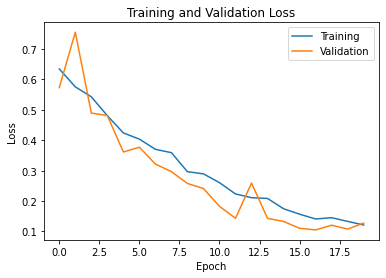

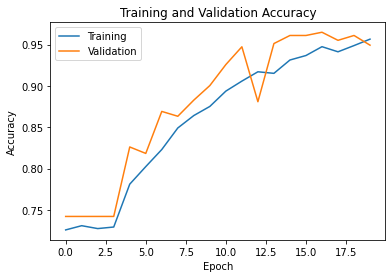

10/10 [==============================] - 12s 1s/step - loss: 0.4347 - output_loss: 0.1519 - output3_loss: 0.1288 - output2_loss: 0.1540 - output_accuracy: 0.9403 - output3_accuracy: 0.9573 - output2_accuracy: 0.9369
Loss & Accuracy Statistics
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Accuracy on Train       > 0.956510066986084 
Loss on Train  	        > 0.12133944779634476
Accuracy on Test        > 0.952136754989624 
Loss on Test   	        > 0.12007889896631241
Accuracy on Validation  > 0.9368600845336914 
Loss on Validation 	> 0.15190105140209198

Predicting Test
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
10/10 [===========

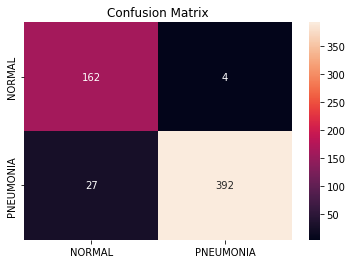

------------------------------------------------------------
Correct Predictions > 554
Wrong Predictions > 31
------------------------------------------------------------
              precision    recall  f1-score   support

      NORMAL       0.86      0.98      0.91       166
   PNEUMONIA       0.99      0.94      0.96       419

    accuracy                           0.95       585
   macro avg       0.92      0.96      0.94       585
weighted avg       0.95      0.95      0.95       585



In [ ]:
# Display all of the results of the Model  
model_summary(googlenet_model, googlenet_history)